In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import csv
import copy
import sklearn.linear_model
import json
import re
from sklearn import preprocessing
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
COLOR_TREAT = "#2ecc71"
COLOR_NO_TREAT = "#e74c3c"
import warnings
warnings.filterwarnings('ignore')

In [153]:
def percent_categorical(item, df=None, grouper='Active Status' , order = None) :
    # plot categorical responses to an item ('column name')
    # by percent by group ('diff column name w categorical data')
    # select a data frame (default is IA)
    # 'Active Status' is default grouper

    # create df of item grouped by status
    grouped = (df.groupby(grouper)[item]
    # convert to percentage by group rather than total count
                .value_counts(normalize=True)
                # rename column 
                .rename('percentage')
                # multiple by 100 for easier interpretation
                .mul(100)
                # change order from value to name
                .reset_index()
                .sort_values(item))

    # create plot
    f, axarr = plt.subplots(1, 2, figsize = (15,8))
    sns.barplot(x=item,
                         y='percentage',
                         hue=grouper,
                         data=grouped,
                         palette='RdBu' , order = order , ax = axarr[0]
                         )
    
    sns.countplot( x = item , data= df , hue = grouper , palette='RdBu' , 
                                order = order , ax = axarr[1])  

# Do the United Nations peace agreements have an impact on conflicts resolution around the world ?

# 1. Introduction

The United Nations often gets criticised for all the wars it could not prevent and its impact in our society has often been questioned. Our study aims at giving an objective analysis of the impact of UN peace agreements on the evolution of conflicts around the world. The results of our analysis will be presented as a data story: we will display information relative to both conflicts and peace treaties on a world map in order to have an insight on the impact they have on one another. We will use a time slider to show the evolution of the aforementioned data through time. Therefore, the world map will, for example, show if a peace treaty brings some kind of stability in a region that was struggling with conflicts.

To perform this, we will use the UCDP dataset which provides the information we need about conflicts and peace agreements from 1975 to 2011.

# 2. Facts about conflicts and Peace Agreements

## 2.1 Conflicts

In [159]:
#For nb of deaths
precisedf = pd.read_csv('data/ged171.csv')

#Import the Peace Agreement dataset and the translation table to get the new IDs
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = [1 if ele in inter else 0 for ele in pa.PAID]
pa[pa['UN'] == 1]

reader = csv.reader(open('data/translate_conf.csv', 'r'))

#Create a dictionnary that will have {New ID : Old ID} so we can make the link
d = {}
for row in reader:
    k, v = row
    d[v] = k
    
#pa.CID = pa.CID.astype(dtype=str).replace(to_replace=d )
pa.CID = pa.CID.astype(str)
#print(type(pa.CID))
pa.CID = pa.CID.apply(lambda x: d[x])
pa.CID = pa.CID.astype(dtype = int)

#Import the conflict dataset
df = pd.read_csv('data/ucdp-prio-acd-171.csv')
df.drop(['sidea2nd', 'sideb2nd' , 'terr' , 'year' , 'intensity' , 'startprec' , 'startdate2' , 'epend' , 'ependprec', 'gwnoa', 'gwnoa2nd', 'gwnob', 'gwnob2nd', 'gwnoloc', 'startprec2', 'version', 'sidebid'], axis=1, inplace = True)
clean_df = df.groupby('conflictid').last()
agreements = pa.groupby('CID').last()
UN_agreements = pa[pa['UN']==1].groupby('CID').last()
Other_agreements = pa[pa['UN']==0].groupby('CID').last()
clean_df["agreement"] = [1 if ele in agreements.index else 0 for ele in clean_df.index]
clean_df["UN_agreement"] = [1 if ele in UN_agreements.index else 0 for ele in clean_df.index]
clean_df["Other_agreement"] = [1 if ele in Other_agreements.index else 0 for ele in clean_df.index]
clean_df.rename({'ependdate':'enddate'} , inplace = True, axis = 1)
clean_df['startdate'] = pd.to_datetime(clean_df['startdate'])
clean_df['enddate'] = pd.to_datetime(clean_df['enddate'])
clean_df['duration'] = (clean_df['enddate'] - clean_df['startdate']).dt.days
regiondic = {'1':'Europe' , '2': 'Middle East', '3': 'Asia' , '4': 'Africa' , '5':'Americas' , '1, 3' : 'Asia',
            '1, 2' : 'Middle East' , '1, 4':'Africa' ,'1, 5': 'Americas','1, 2, 3, 5' :'Middle East' , '1, 3, 5' : 'Middle East'}
typedic = {1 : 'Extrasystemic' , 2 : 'Interstate' , 3 : 'Internal' , 4: 'Internationalized'}
incompdic = {1 : 'Territory' , 2: 'Government' , 3: 'Government and Territory'}
cumintdic = {0: 'Less than 1000 deaths' , 1: 'More than 1000 deaths'}
clean_df.region.replace(regiondic , inplace= True)
clean_df.type.replace(typedic , inplace= True)
clean_df.incomp.replace(incompdic , inplace = True)
clean_df.cumint.replace(cumintdic , inplace = True)
ag = clean_df[clean_df['agreement'] == 1]
clean_df[clean_df['agreement'] == 1].head()

,location,sidea,side b,incomp,cumint,type,startdate,enddate,region,agreement,UN_agreement,Other_agreement,duration
conflictid,,,,,,,,,,,,,
209,Philippines,Government of Philippines,CPP,Government,More than 1000 deaths,Internal,1946-07-31,2016-08-20,Asia,1,0,1,25588.0
233,Guatemala,Government of Guatemala,URNG,Government,More than 1000 deaths,Internal,1949-07-18,1995-12-31,Americas,1,1,1,16967.0
234,Israel,Government of Israel,"Hamas, PIJ",Territory,More than 1000 deaths,Internal,1948-05-15,2014-12-24,Middle East,1,0,1,24329.0
269,Nepal,Government of Nepal,CPN-M,Government,More than 1000 deaths,Internal,1960-02-29,2006-09-21,Asia,1,1,1,17006.0
282,Sudan,Government of Sudan,SSLM,Territory,More than 1000 deaths,Internal,1963-12-31,1972-01-31,Africa,1,0,1,2953.0


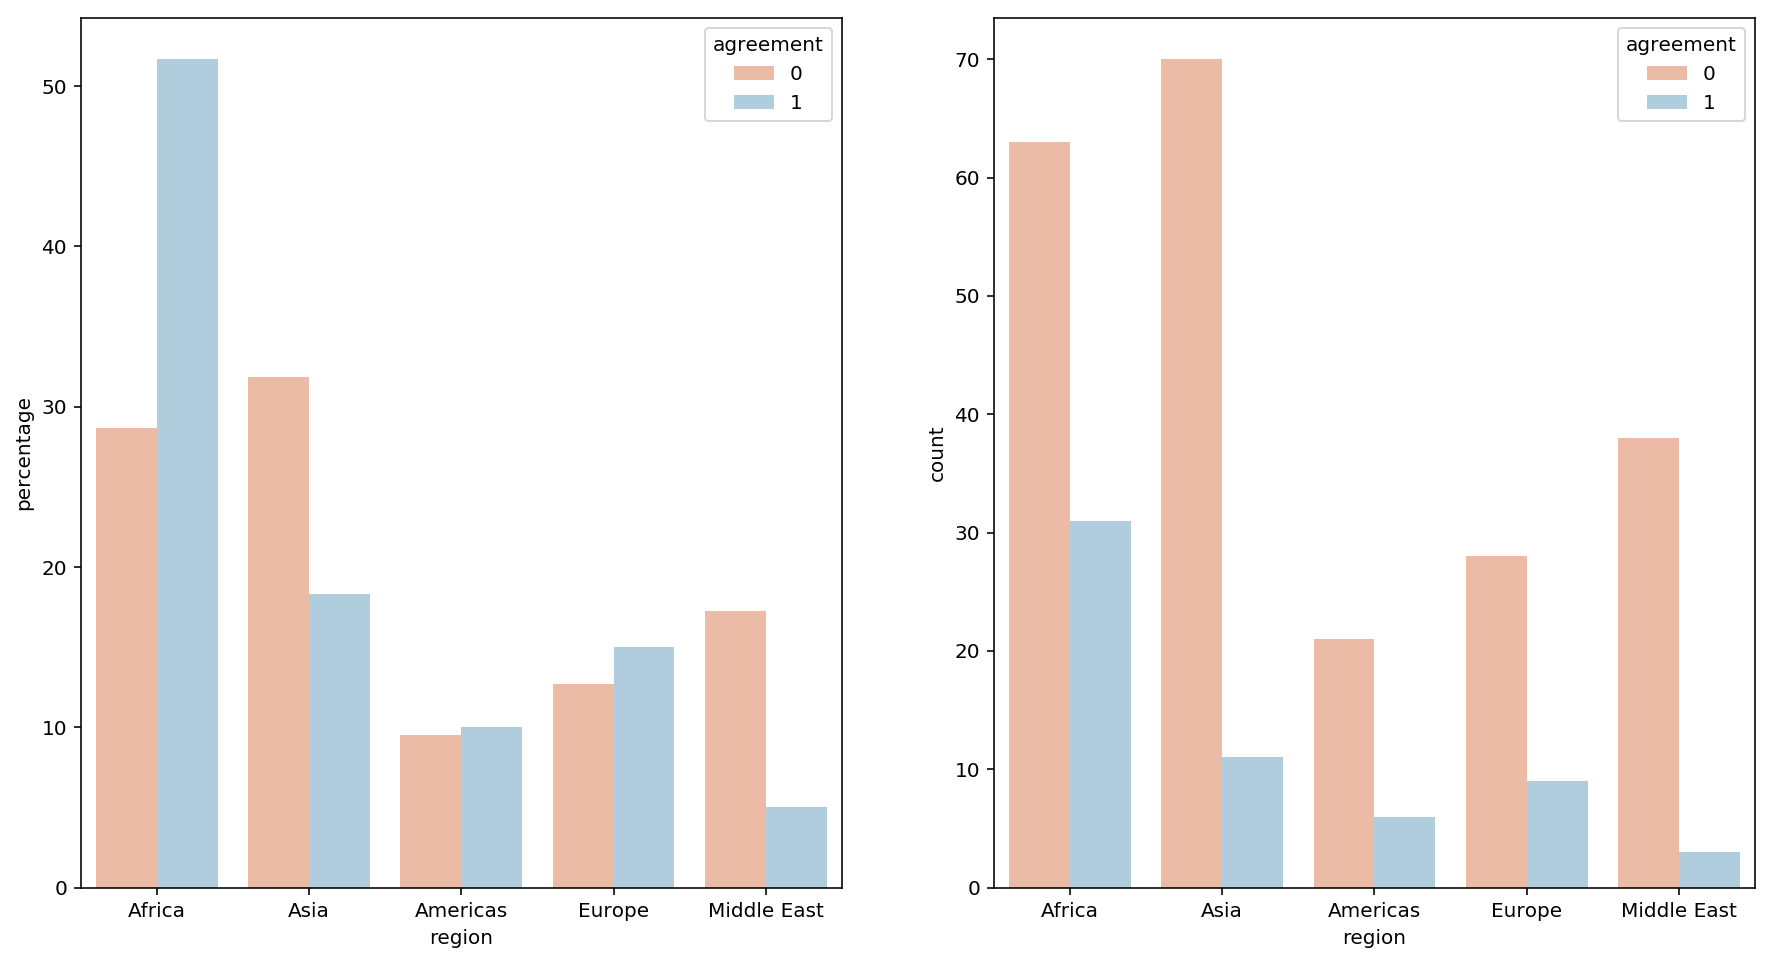

In [164]:
percent_categorical('region' , df= clean_df , grouper = 'agreement' , order = ['Africa' , 'Asia' , 'Americas' , 'Europe' , 'Middle East'])

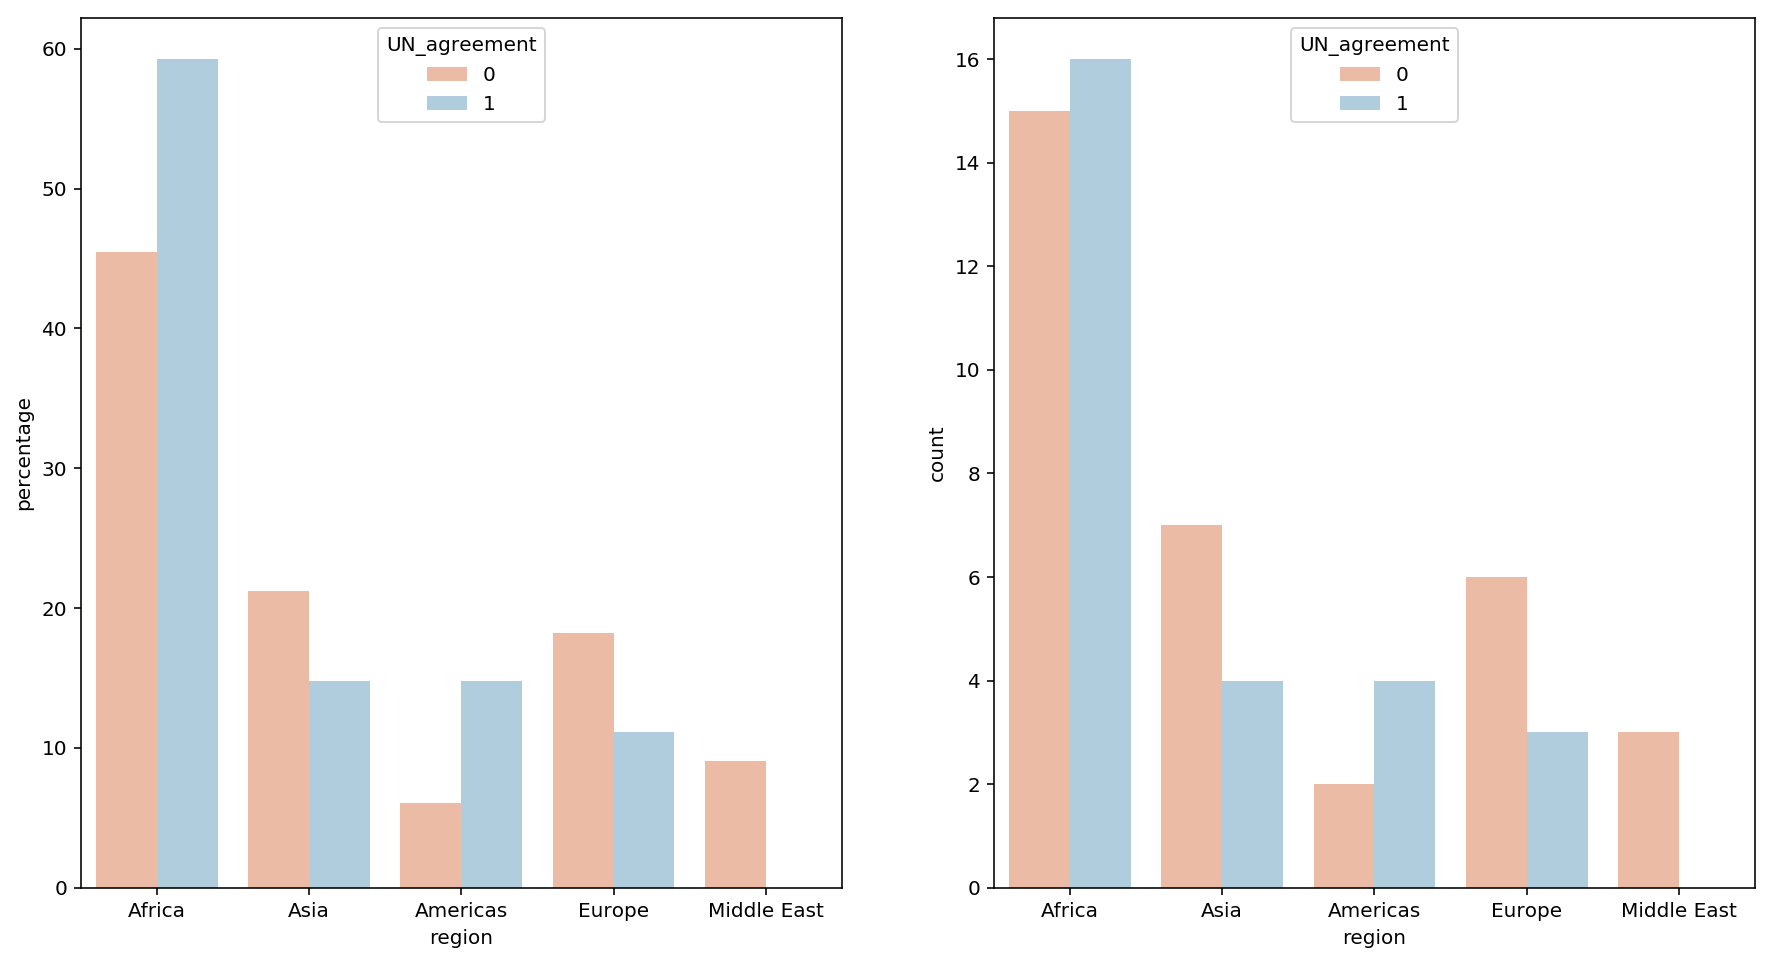

In [155]:
percent_categorical('region' , df= ag , grouper = 'UN_agreement' , order = ['Africa' , 'Asia' , 'Americas' , 'Europe' , 'Middle East']);

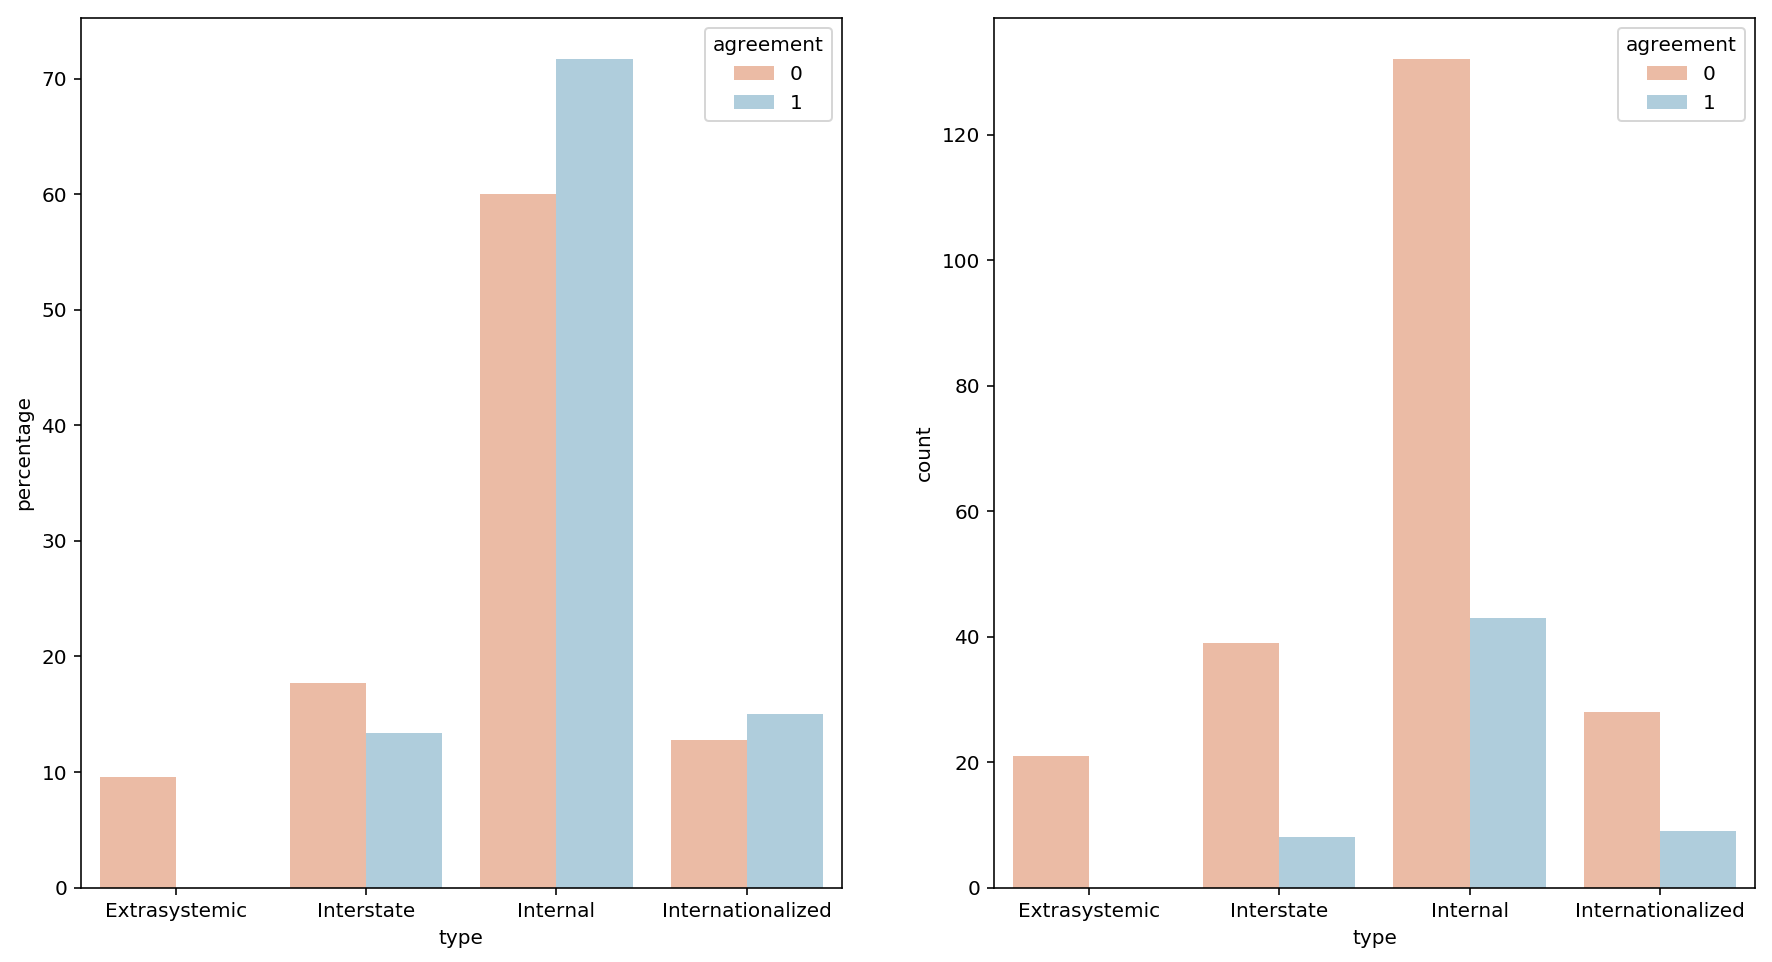

In [160]:
percent_categorical('type' , df= clean_df , grouper = 'agreement' , order = ['Extrasystemic' , 'Interstate' , 'Internal' , 'Internationalized']);

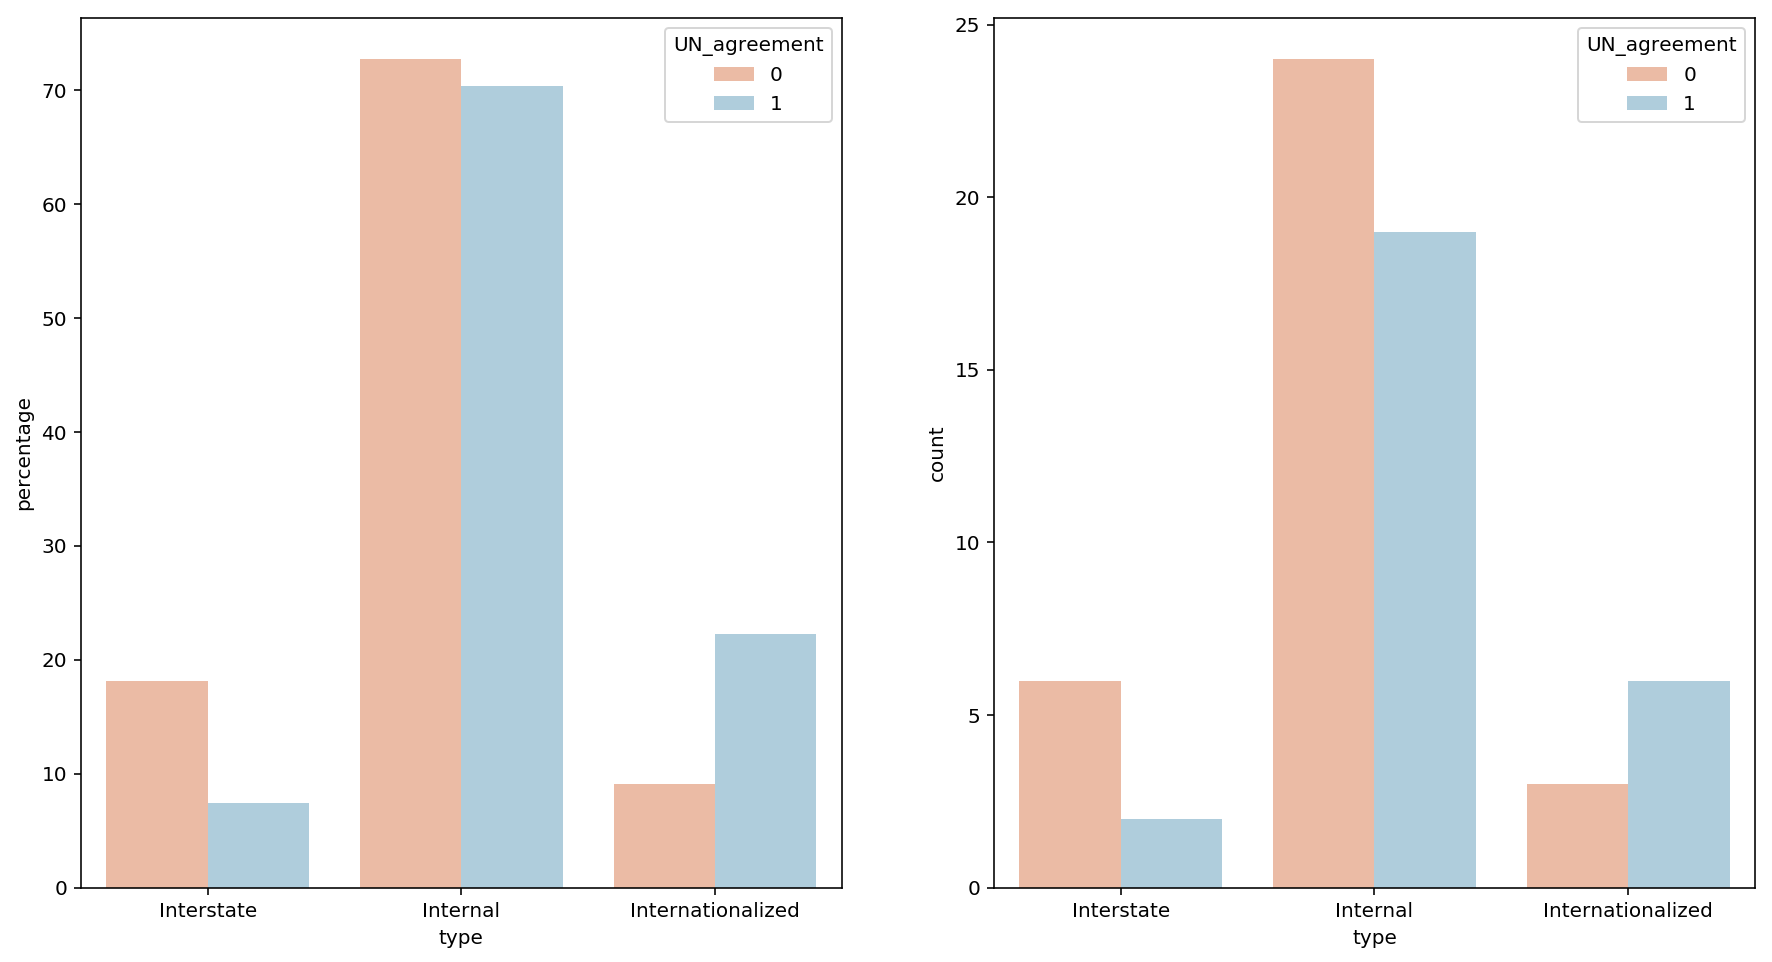

In [162]:
percent_categorical('type' , df= ag , grouper = 'UN_agreement' , order = ['Interstate' , 'Internal' , 'Internationalized']);

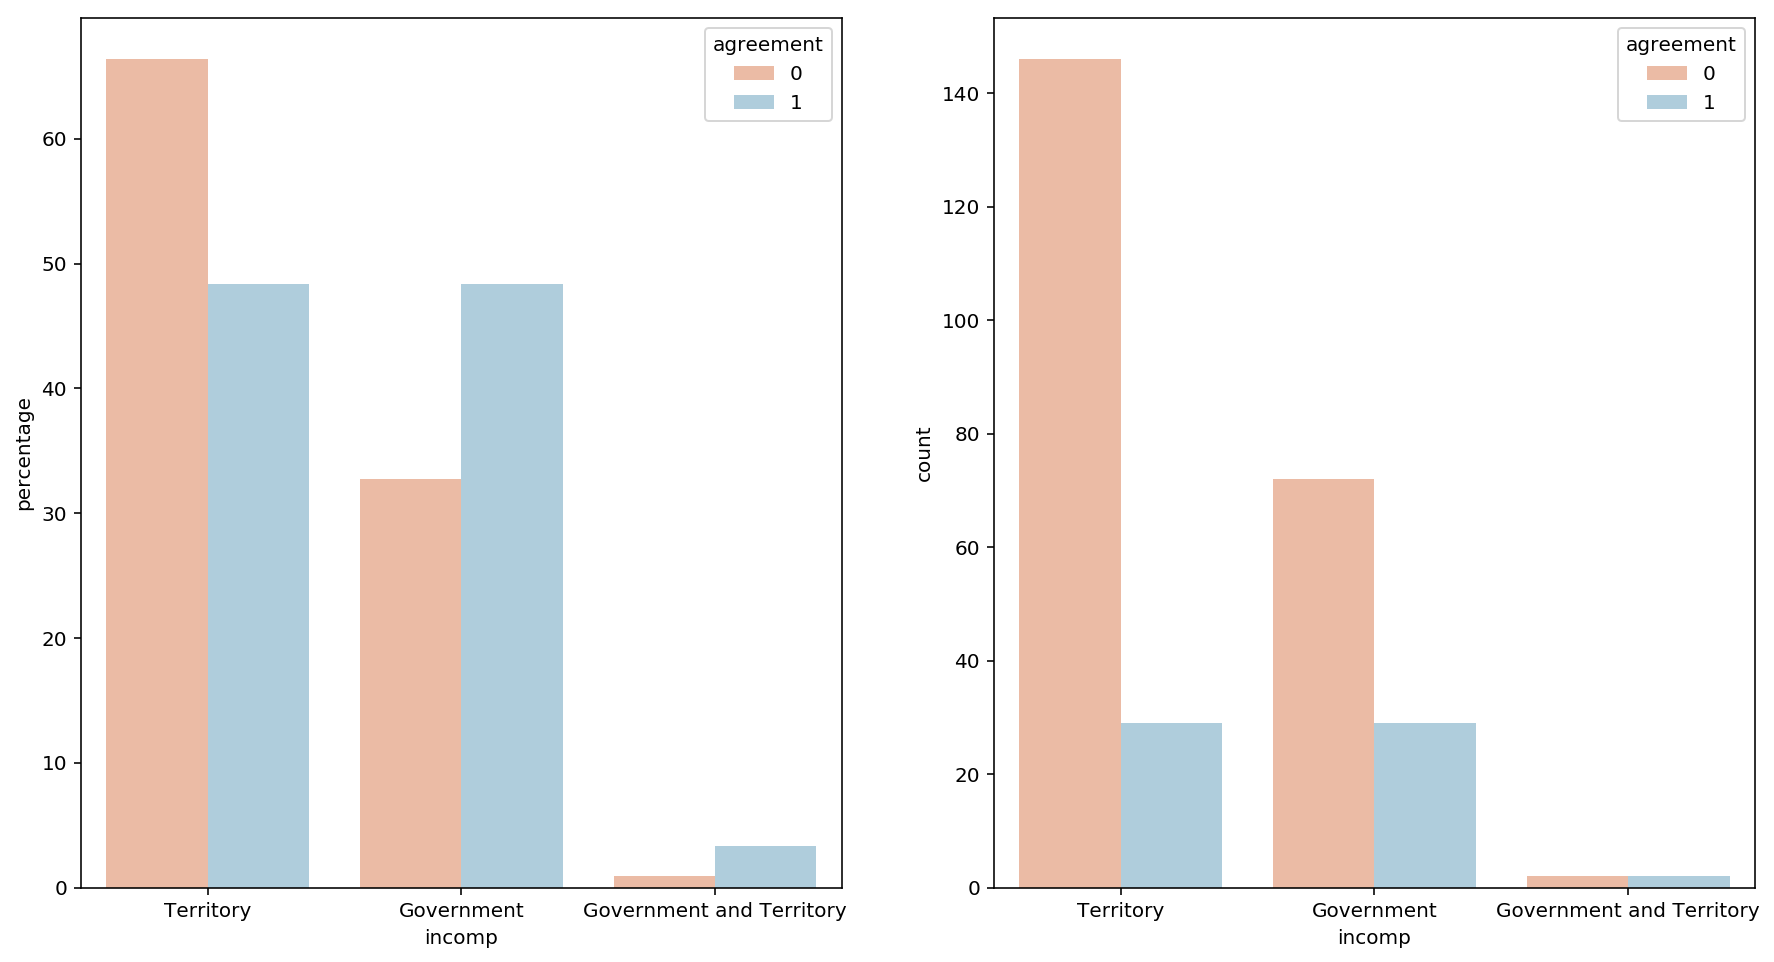

In [165]:
percent_categorical('incomp' , df= clean_df , grouper = 'agreement' , 
                    order = [ 'Territory' , 'Government' , 'Government and Territory'] )

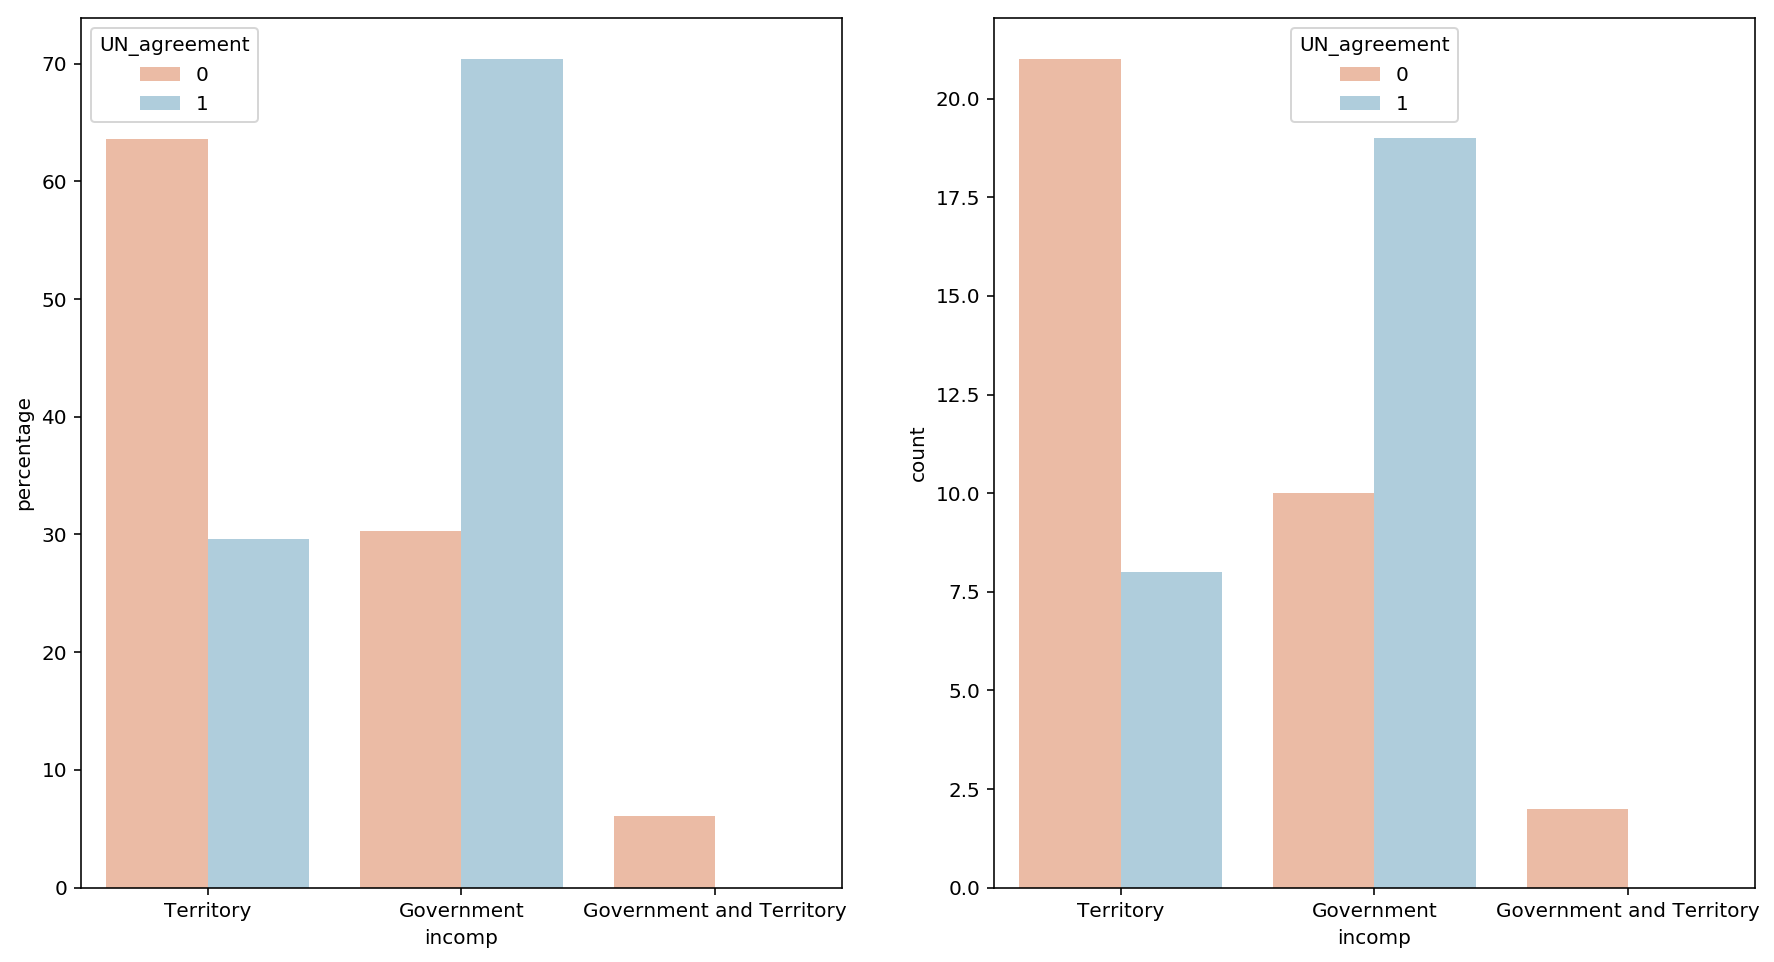

In [166]:
percent_categorical('incomp' , df= ag , grouper = 'UN_agreement' , 
                    order = [ 'Territory' , 'Government' , 'Government and Territory'] )

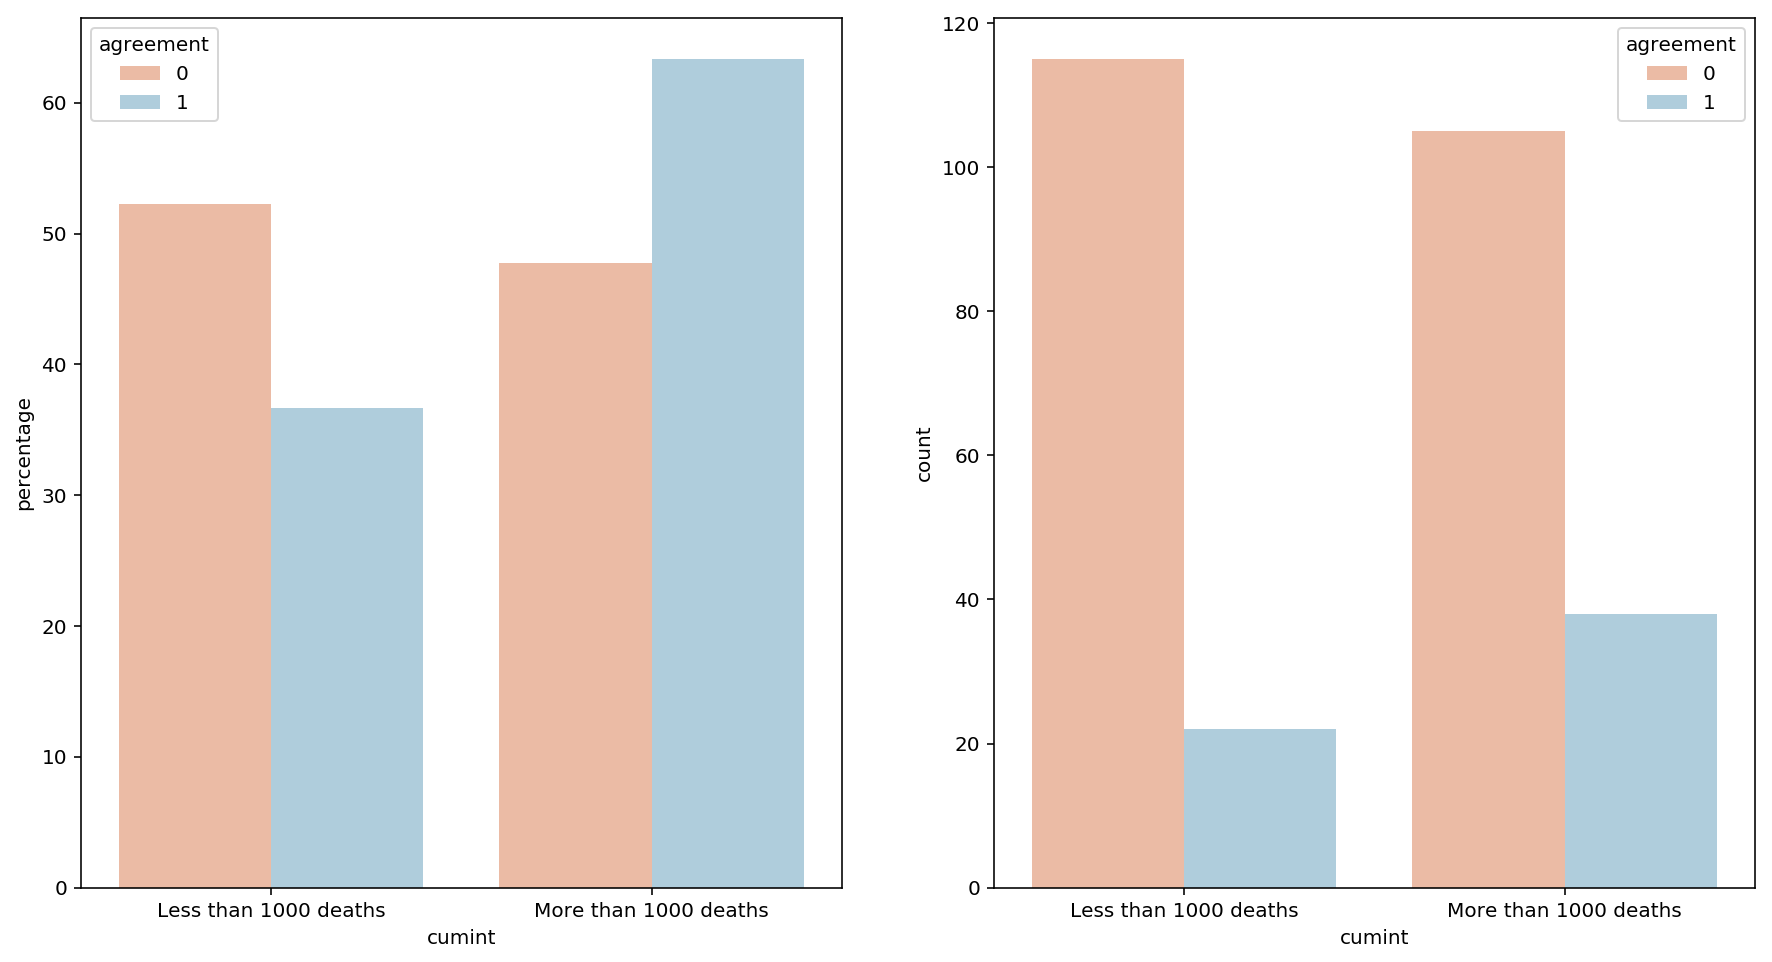

In [172]:
percent_categorical('cumint' , df= clean_df , grouper = 'agreement' , 
                    order = ['Less than 1000 deaths' , 'More than 1000 deaths'] )

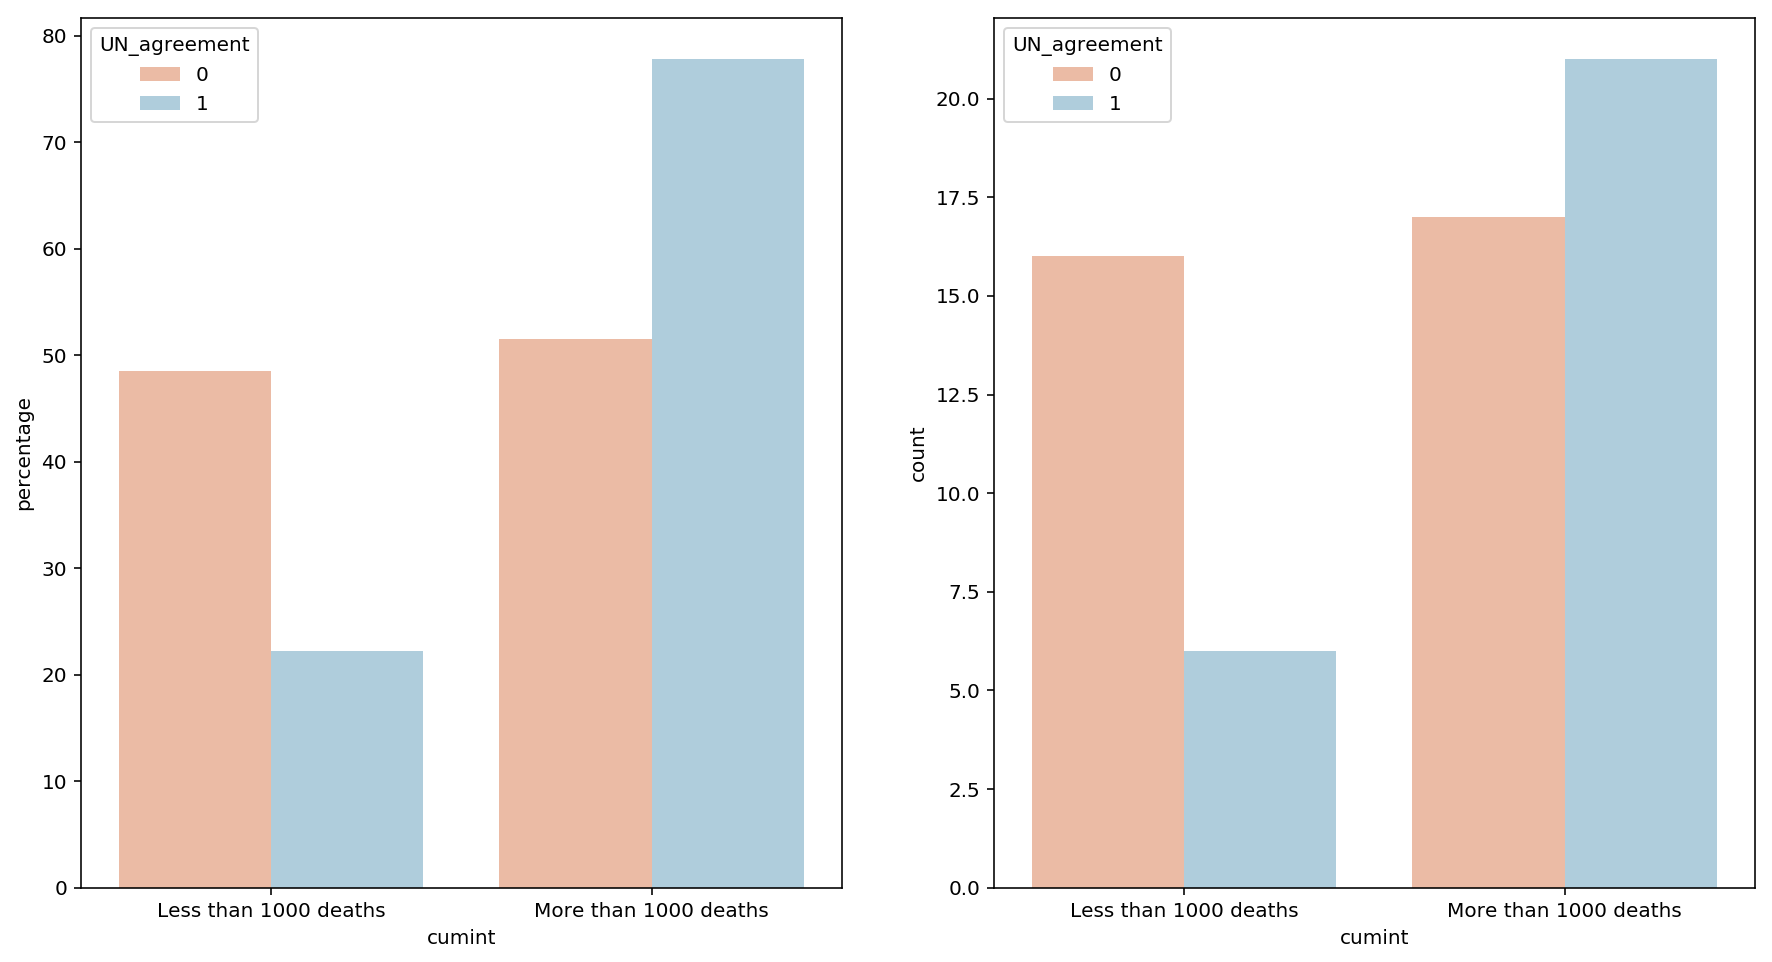

In [173]:
percent_categorical('cumint' , df= ag , grouper = 'UN_agreement' , 
                    order = ['Less than 1000 deaths' , 'More than 1000 deaths'] )

## 2.2 Peace Agreements

# 3. Impact of the UN

# 4. Map

# 5. Conclusions

,location,sidea,side b,incomp,cumint,type,startdate,enddate,region,agreement,UN_agreement,Other_agreement,duration
conflictid,,,,,,,,,,,,,
298,South Africa,Government of South Africa,SWAPO,Territory,More than 1000 deaths,Internal,1966-08-26,1988-08-08,Africa,1,1,0,8018.0
369,Papua New Guinea,Government of Papua New Guinea,BRA,Territory,Less than 1000 deaths,Internal,1989-04-06,1996-11-28,Asia,1,1,1,2793.0
390,Croatia,Government of Croatia,Serbian Republic of Krajina,Territory,More than 1000 deaths,Internal,1992-04-29,1995-09-06,Europe,1,1,0,1225.0
392,Georgia,Government of Georgia,Republic of Abkhazia,Territory,More than 1000 deaths,Internal,1992-08-14,1993-11-29,Europe,1,1,0,472.0
405,"Cameroon, Nigeria",Government of Cameroon,Government of Nigeria,Territory,Less than 1000 deaths,Interstate,1994-02-18,1996-05-07,Africa,1,1,0,809.0
407,Comoros,Government of Comoros,MPA/Republic of Anjouan,Territory,Less than 1000 deaths,Internal,1997-09-03,1997-09-05,Africa,1,1,1,2.0
409,"Eritrea, Ethiopia",Government of Eritrea,Government of Ethiopia,Territory,More than 1000 deaths,Interstate,1998-05-06,2016-06-13,Africa,1,1,0,6613.0
412,Serbia (Yugoslavia),Government of Serbia (Yugoslavia),UCK,Territory,More than 1000 deaths,Internationalized,1996-04-22,1999-11-21,Europe,1,1,0,1308.0
